In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds

%run ../DDELFI.py

import scipy as sp

from delfi.simulator.BaseSimulator import BaseSimulator

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
from delfi.utils.viz import plot_pdf

from delfi.simulator import Gauss

from tqdm import tqdm_notebook as tqdm

from parameters import ParameterSet

%matplotlib notebook

In [2]:
def plot_pdf_2d(params, dist, label = None):
    lims = 2 * np.linalg.norm(params.obs_stats)
    xlist = np.linspace(-lims, lims, 80)
    ylist = np.linspace(-lims, lims, 80)
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111, projection='3d')
    
    X, Y = np.meshgrid(xlist, ylist)
    xys = np.asarray((X.ravel(), Y.ravel())).T
    
    if label is not None:
        fig.suptitle(label)
        
    Z = dist.eval(xys, log=False).reshape(X.shape)
    ax.plot_surface(X, Y, Z, cmap=cm.plasma, rstride=1, cstride=1, linewidth=0, antialiased=False)
        
    ax.set_xlabel("$\\theta_1$")
    ax.set_ylabel("$\\theta_2$")
    ax.set_zlabel("$p(\\theta)$")
    plt.show()
    
    return fig

In [3]:
class DividedPdf:
    def __init__(self, a, b, norm_region):
        self.a = a
        self.b = b
        
        
        self.ndim = self.a.ndim
        
        self.Z = 1
        
        xlist = np.linspace(norm_region[0], norm_region[1], 1000)
        samples = self.eval(xlist.reshape(-1,1), log=False)
        
        dx = xlist[1] - xlist[0]
        
        mass = np.sum(samples) * dx
        self.Z = mass
        
    def eval(self, samples, log=True):
        ret = self.a.eval(samples, log=False) / self.b.eval(samples, log=False)
        ret /= self.Z
        if log:
            return np.log(ret)
        else:
            return ret
    
class MultipliedPdf:
    def __init__(self, a, b, norm_region):
        self.a = a
        self.b = b
        
        self.ndim = self.a.ndim
        
        self.Z = 1
        
        xlist = np.linspace(norm_region[0], norm_region[1], 1000)
        samples = self.eval(xlist.reshape(-1,1), log=False)
        
        dx = xlist[1] - xlist[0]
        
        mass = np.sum(samples) * dx
        self.Z = mass
        
    def eval(self, samples, ii=None, log=True):
        ret = self.a.eval(samples, ii=ii, log=False) * self.b.eval(samples, ii=ii, log=False)
        ret /= self.Z
        if log:
            return np.log(ret)
        else:
            return ret
    
def divide_dists(a, b, norm_region):
    if isinstance(a, dd.Gaussian) and isinstance(b, dd.Gaussian):
        return a / b
    
    return DividedPdf(a, b, norm_region)

def multiply_dists(a, b, norm_region):
    if isinstance(a, dd.Gaussian) and isinstance(b, dd.Gaussian):
        return a * b
    
    return MultipliedPdf(a, b, norm_region)

In [4]:
def gen_random_mog(n_comps, ndim, dirichlet_alpha, x_width, dof, scale):
    a = np.random.dirichlet(dirichlet_alpha * np.ones(n_comps))
    ms = np.random.uniform(-x_width, x_width, size=(n_comps, ndim))
    
    Sgen = sp.stats.invwishart(df=dof, scale=scale*np.eye(ndim))
    Ss = Sgen.rvs(size=n_comps).reshape(-1, ndim, ndim)
    
    ret = dd.MoG(a=a, ms=ms, Ss=Ss)
    return ret

In [28]:
def run_DDELFI(params):
    m = Gauss(params.ndim, params.noise_cov, seed=params.seed)
    s = ds.Identity(1)
    g = dg.Default(model=m, prior=params.prior, summary=s)
    
    res = DDELFI(g, obs=[params.obs_stats], 
                     n_hiddens=params.n_hiddens, 
                     n_components=params.n_comps, 
                     seed=params.seed, 
                     prior_mixin=params.prior_mixin,
                     #convert_to_T=3,
                     #svi=False,
                     verbose=True)
    
    ret = res.run(n_train=params.n_train, n_rounds = params.n_rounds, 
                  mog_nsamples=30000, mog_es_rounds=250)

    posteriors = ret[2]
    preds = ret[3]
    return res, posteriors, preds

In [29]:
def compute_post_with_norm(prior, like, x):
    n = prior.ndim
    post_P = prior.P + like.P
    post_S = np.linalg.inv(post_P)
    post_mean_untransf = np.dot(prior.P, prior.m) + np.dot(like.P, x)
    post_mean = np.dot(post_S, post_mean_untransf)
    
    pref = (1 / (2 * np.pi * np.linalg.det(post_P)) * (np.linalg.det(prior.P) * np.linalg.det(like.P)) ) ** (n / 2)
    expt = np.exp(0.5 * (np.dot(post_mean.T, np.dot(post_P, post_mean)) \
                         - np.dot(prior.m.T, np.dot(prior.P, prior.m)) - np.dot(x.T, np.dot(like.P, x))))
    
    return dd.Gaussian(m=post_mean, S=post_S), pref * expt

In [30]:
def compute_post_mog(prior, like, x):
    rets = [ compute_post_with_norm(comp, like, x) for comp in prior.xs ]
    a = np.array([ ap * ret[1] for ap, ret in zip(prior.a, rets) ])
    a /= np.sum(a)
    xs = [ ret[0] for ret in rets ]
    return dd.MoG(a=a, xs=xs)

In [48]:
params = ParameterSet({})

params.seed = 394
params.ndim = 5
params.n_comps = 2 
params.n_hiddens = [ params.n_comps * params.ndim * 2 ] * 2

params.noise_cov = 0.5

params.n_train = 750
params.n_rounds = 5

params.prior_mixin = 0.1

params.dof = params.ndim + 150
params.scale = 20
params.dirichlet_alpha = 15
params.prior_width = 2

params.prior = gen_random_mog(params.n_comps, params.ndim, params.dirichlet_alpha, 
                              0.9 * params.prior_width, params.dof, params.scale)

params.true_params = np.zeros(params.ndim)
params.obs_stats = np.zeros(params.ndim)

params.like = dd.Gaussian(m=np.zeros(params.ndim), S=params.noise_cov * np.eye(params.ndim))

params.gt = compute_post_mog(params.prior, params.like, params.obs_stats)

<IPython.core.display.Javascript object>


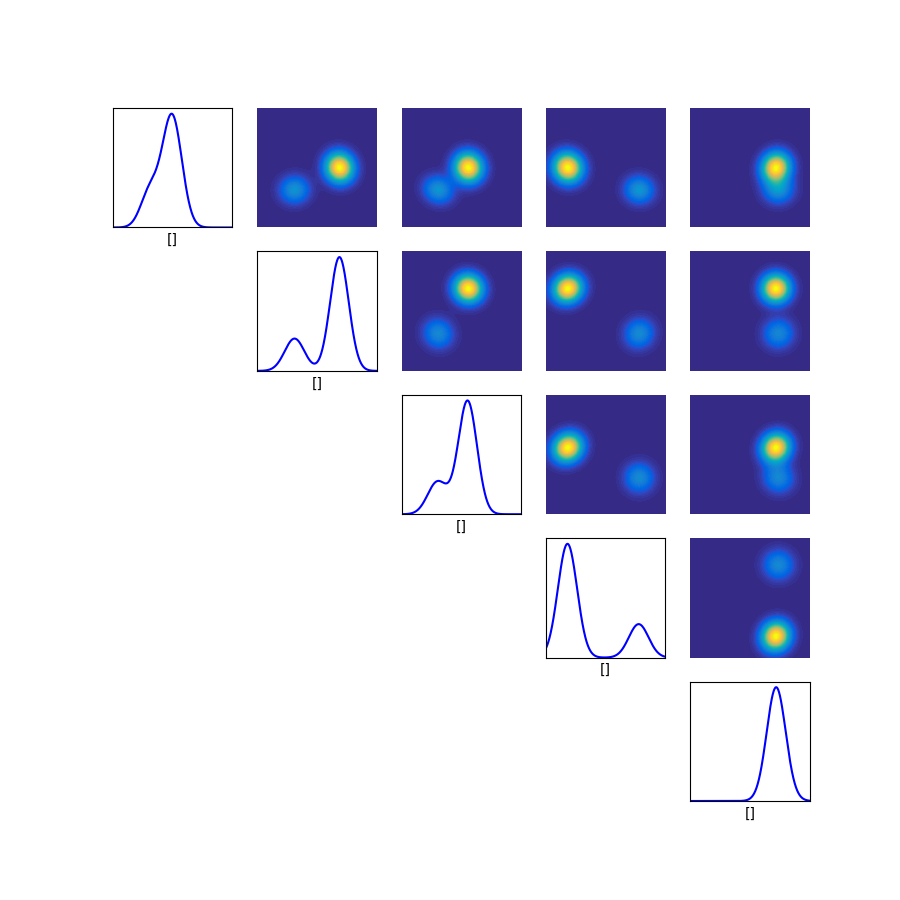

In [49]:
plot_pdf(params.gt,
         lims=[-params.prior_width,params.prior_width],  
         figsize=(9,9));

In [18]:
params.n_rounds = 5
params.prior_mixin = 0.1

In [50]:
std_params = params

res, posteriors, preds = run_DDELFI(std_params)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

0it [00:00, ?it/s]

loss=[ 1.82315421]: : 1454it [01:17, 18.65it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 0.89874291]: : 0it [00:00, ?it/s]

loss=[ 0.41443563]: : 693it [00:27, 25.60it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

0it [00:00, ?it/s]

loss=[ 0.83062851]: : 389it [00:25, 15.24it/s]


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

loss=[ 1.33493686]: : 0it [00:00, ?it/s]

loss=[ 0.87983418]: : 689it [00:30, 22.60it/s]


<IPython.core.display.Javascript object>


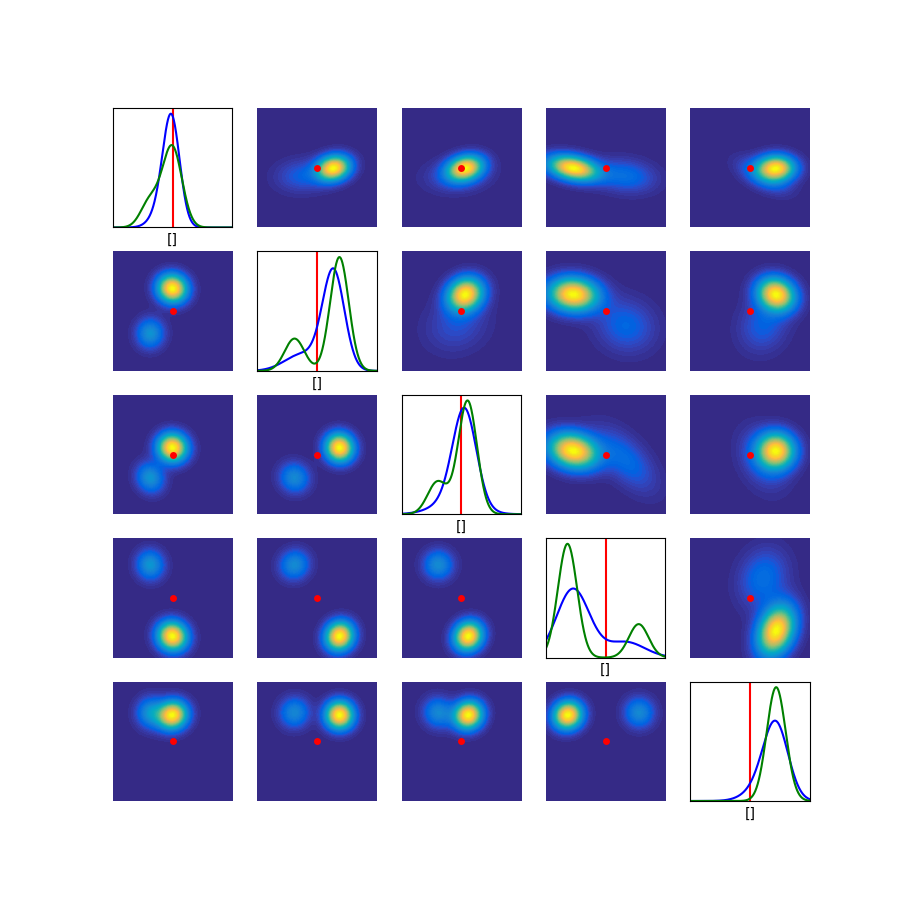

<IPython.core.display.Javascript object>


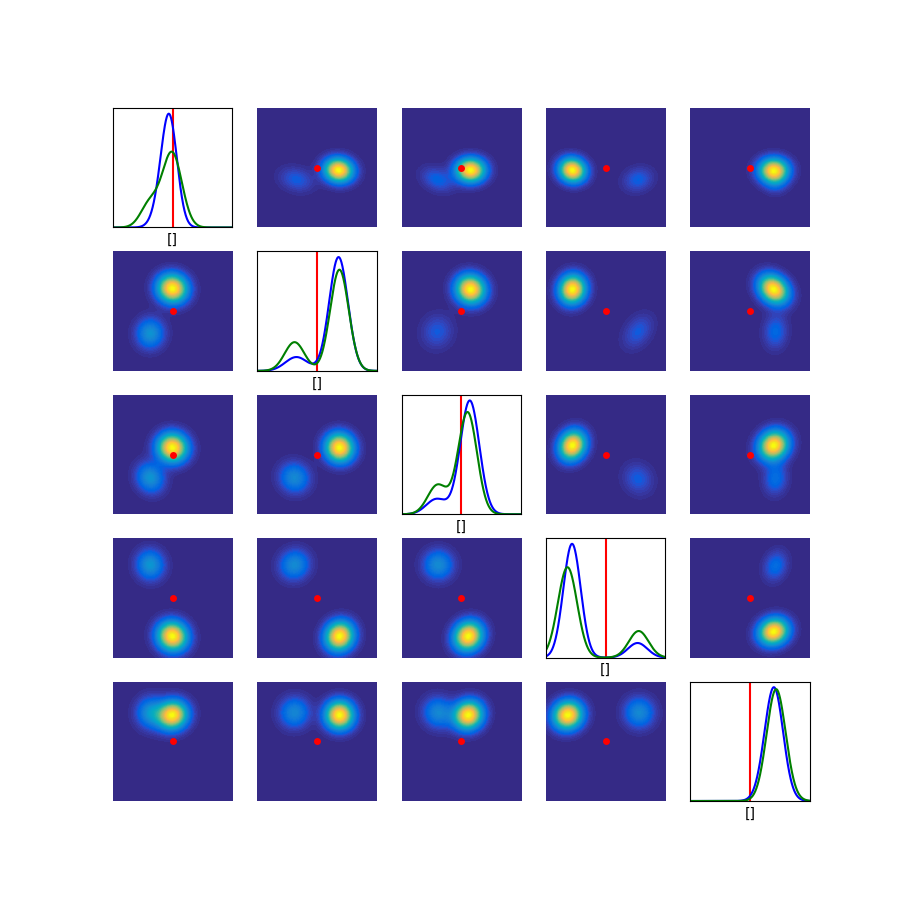

<IPython.core.display.Javascript object>


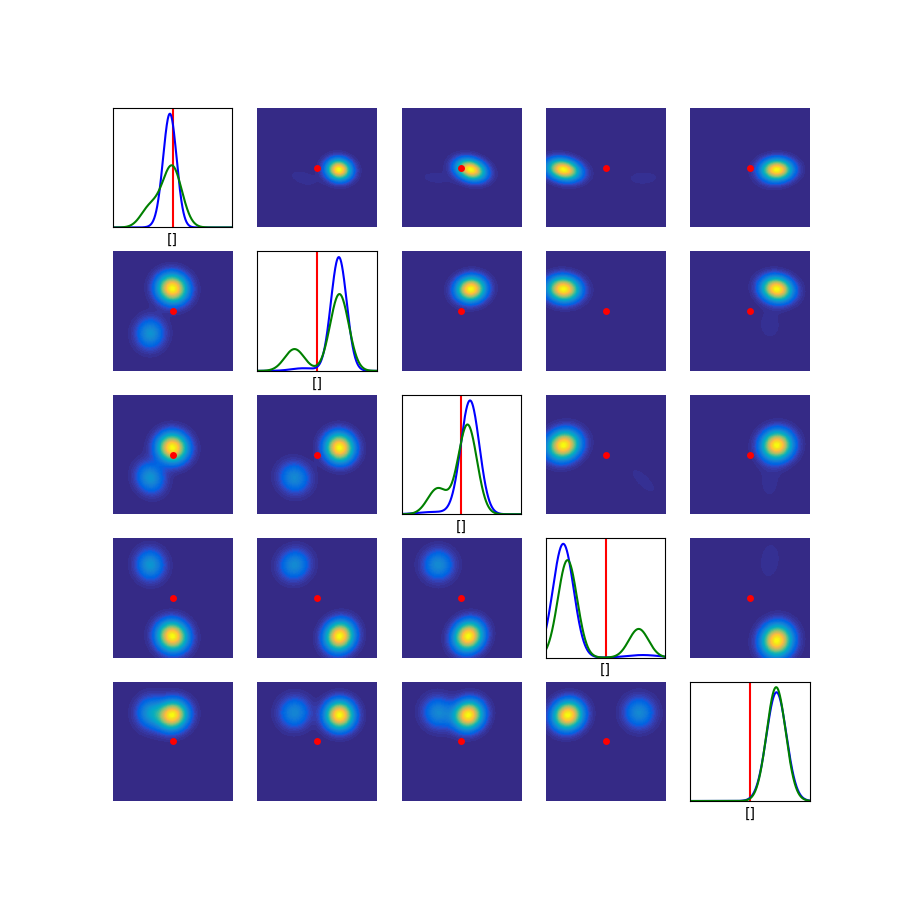

<IPython.core.display.Javascript object>


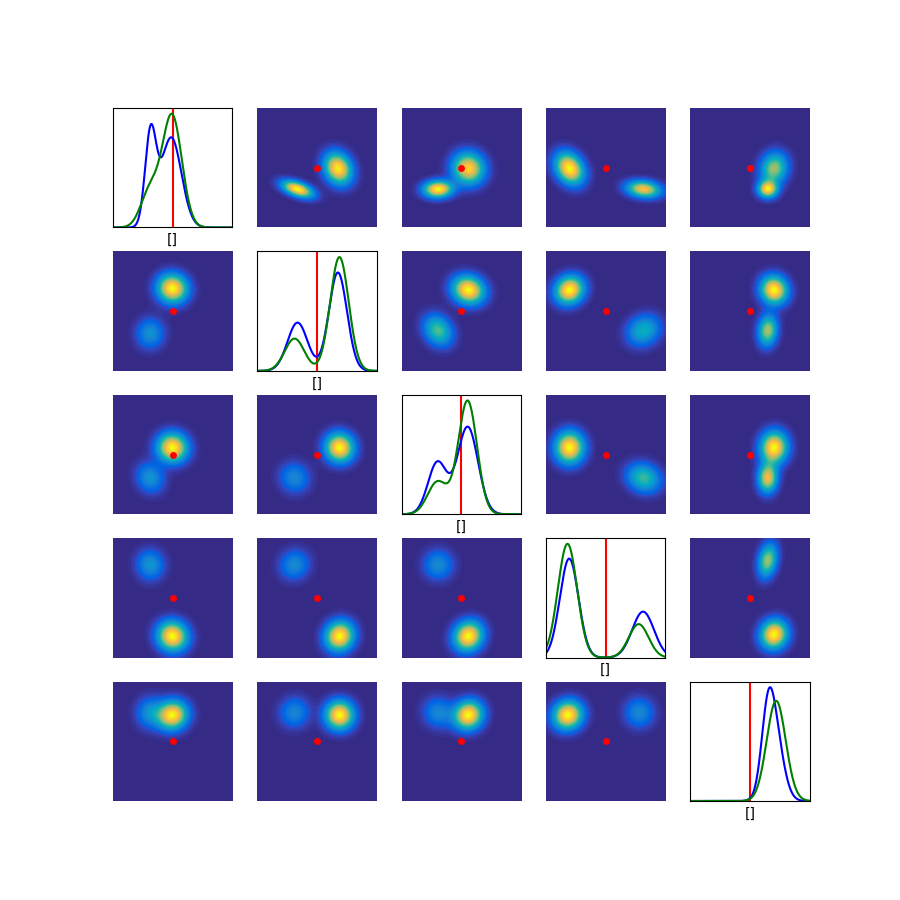

<IPython.core.display.Javascript object>


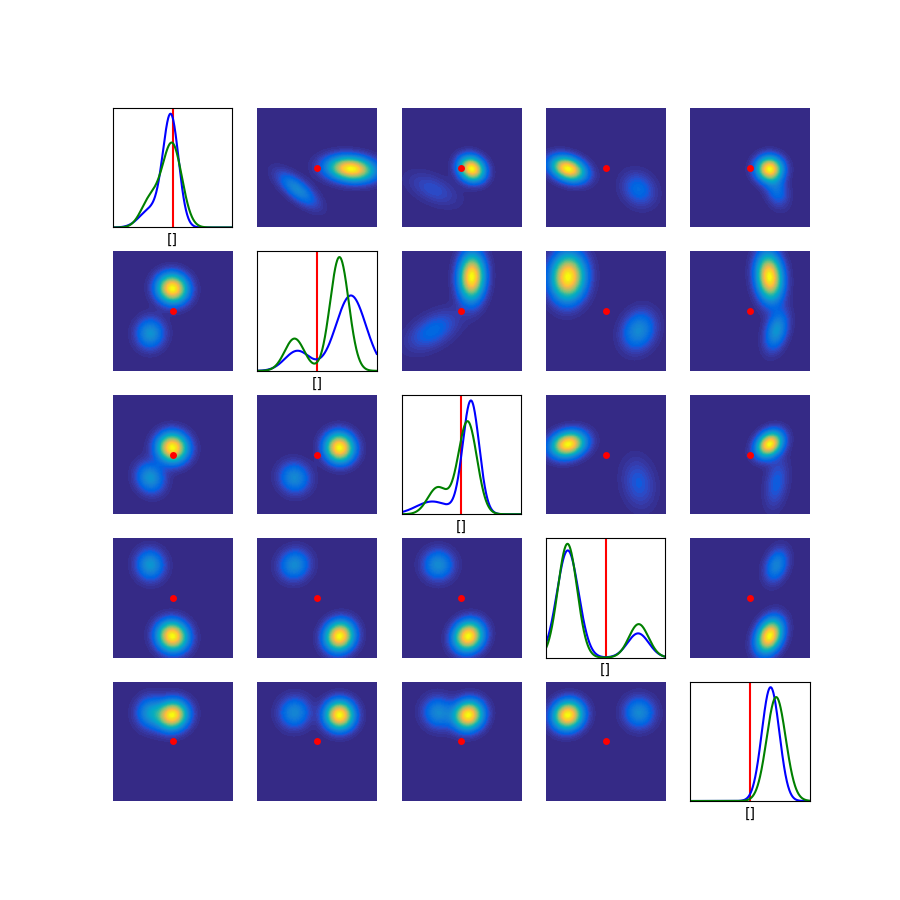

In [51]:
for r, posterior in enumerate(posteriors[0:]):
    plot_pdf(posterior, 
             pdf2 = params.gt,
             lims=[-params.prior_width,params.prior_width],  
             gt=params.true_params, 
             figsize=(9,9));

<IPython.core.display.Javascript object>


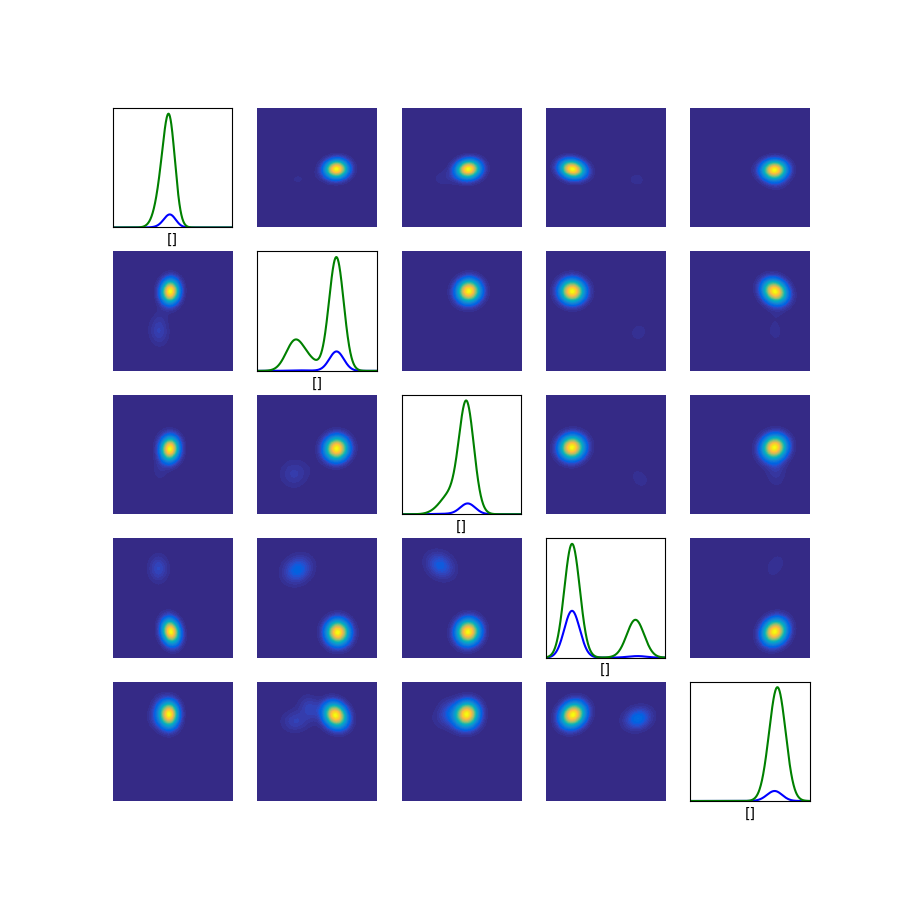

<IPython.core.display.Javascript object>


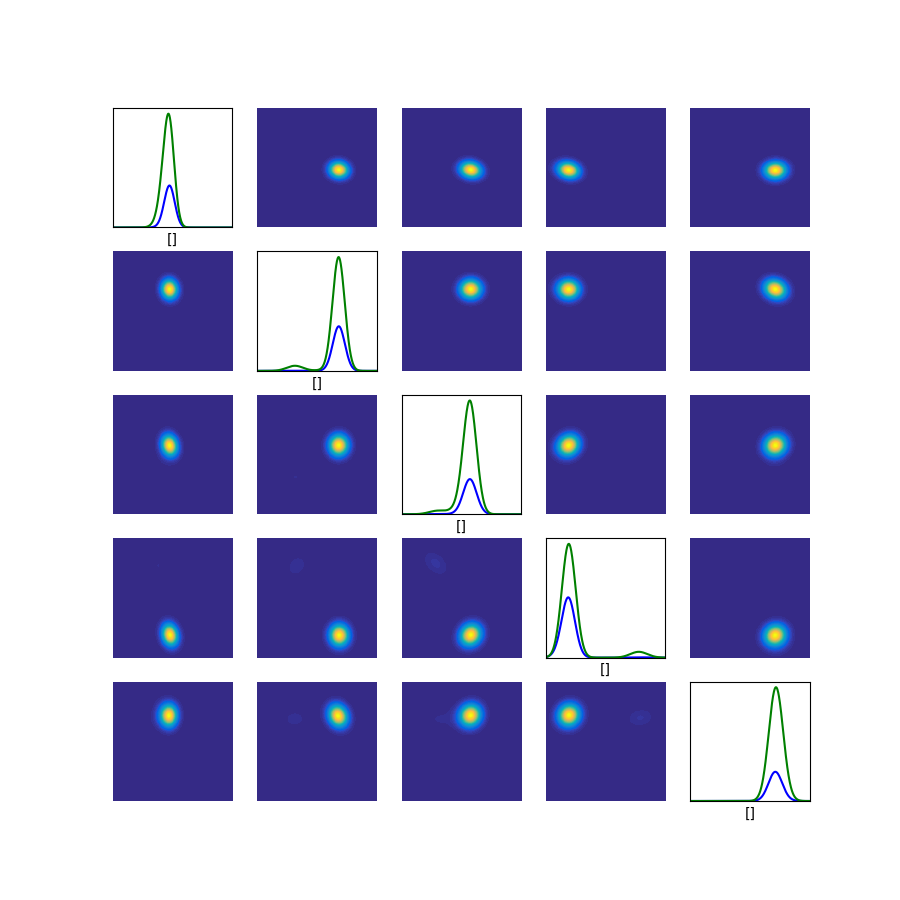

<IPython.core.display.Javascript object>


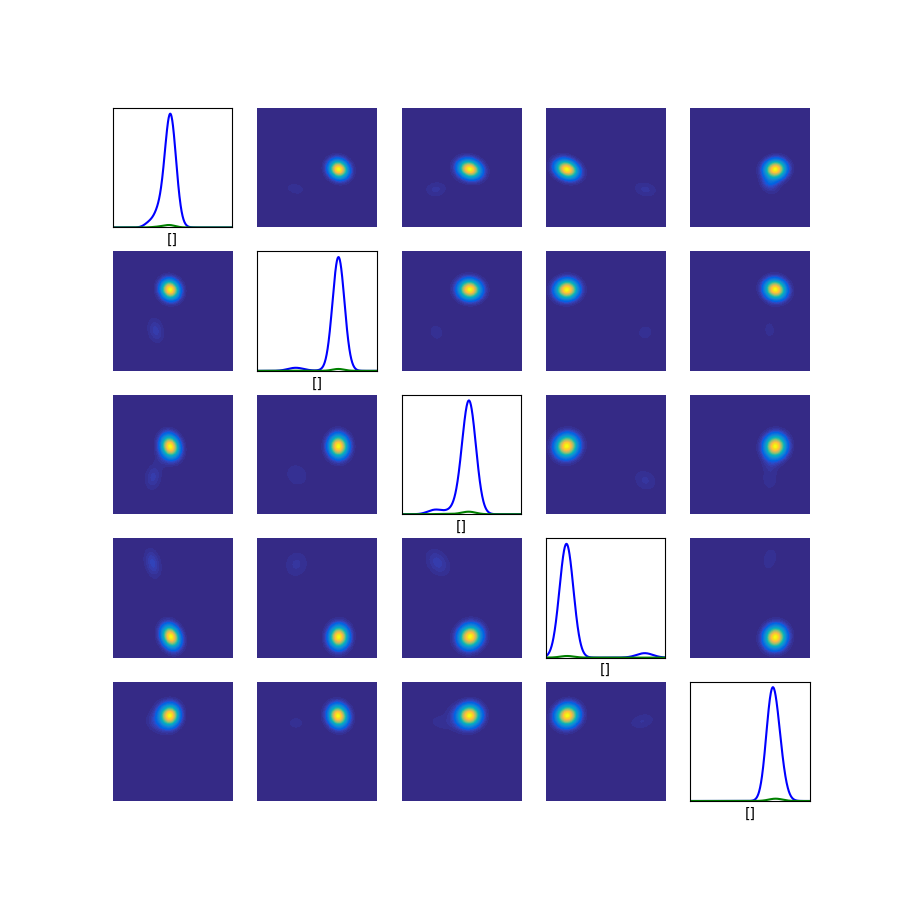

<IPython.core.display.Javascript object>


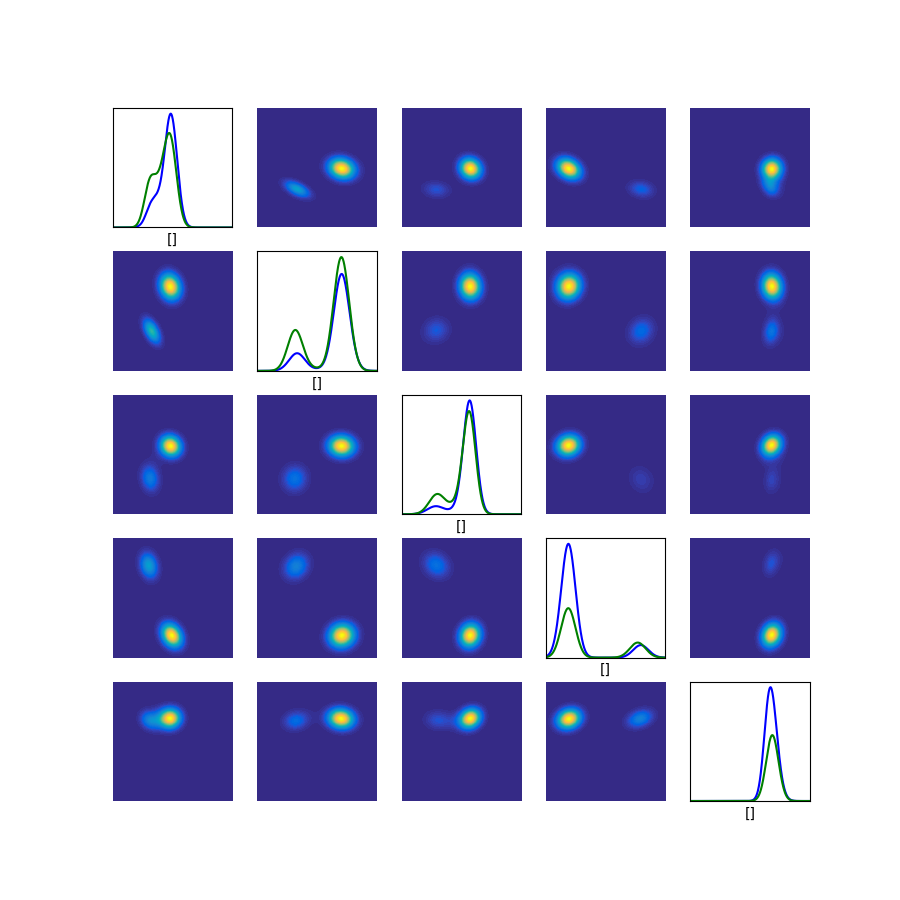

In [52]:
for pred in preds[1:]:
    lhs = multiply_dists(pred['proposal'], pred['posterior'], (-params.prior_width * 5, params.prior_width * 5))
    rhs = multiply_dists(pred['prior'], pred['qphi'], (-params.prior_width * 5, params.prior_width * 5))
    
    plot_pdf(lhs, 
             pdf2 = rhs,
             lims=[-params.prior_width,params.prior_width],  
             figsize=(9,9));